# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

### Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [2]:
PATH = '/datasets/faces/'
PATH_FOR_FOTOS = '/datasets/faces/final_files/'

In [3]:
df_labels = pd.read_csv(PATH + 'labels.csv')

### EDA

In [4]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Размер выборки выведен. Выборка относительно небольшая, но мы еще можем нарастить ее, применяя аугментации.


In [5]:
df_labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Функция для построение графика и вывода статистических данных

In [6]:
class style:
    BOLD = '\033[1m'
    END = '\033[0m'

In [7]:
def hist_box_describe(df, col, binwidth=1):
    print(f'{style.BOLD}'
          f'Статистические данные распределения возраста в выборке:'
          f'{style.END}')
    display(df[col].describe())
    print(f'{style.BOLD}'
          f'График распределения возраста в выборке:'
          f'{style.END}')
    
    fig,ax = plt.subplots(2,1,sharex=True,figsize=(12,8),gridspec_kw={'height_ratios': [4, 1]})

    sns.histplot(data=df,x=col,
                 binwidth=binwidth,
                 ax=ax[0])

    sns.boxplot(data=df,x=col,ax=ax[1])
    
    return fig,ax

Статистические данные распределения возраста в выборке:


count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

График распределения возраста в выборке:


(<Figure size 864x576 with 2 Axes>,
 array([<AxesSubplot:xlabel='real_age', ylabel='Count'>,
        <AxesSubplot:xlabel='real_age'>], dtype=object))

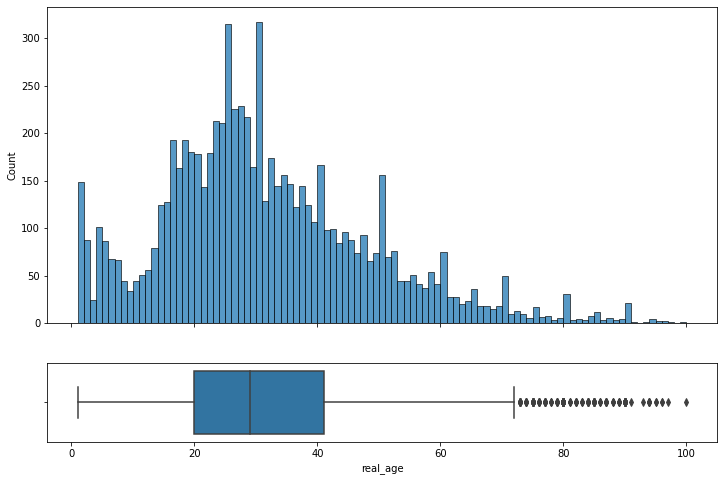

In [8]:
hist_box_describe(df_labels, 'real_age')

* Данные распределенны нормально;
* На круглых датах (25, 30, 40, 50 лет и т.д.) заметны сильные скачки, это может быть связанно с тем что при разметки данных, настоящий возраст людей был известен не всегда, эти некорректные данные могут повлиять на качество модели.

Статистические данные:

* Размер выборки - 7591;
* Средний возраст - 31 год, медианный - 29 лет;
* Минимальный возраст - 1 год;
* Максимальный возраст - 100 лет.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b>  
    
Гистограмма целевого признака выведена. Раз у нас 100 различных возрастов, то и корзин можно указать столько же.
        
Так ты увидишь пики в районе "юбилейных" лет, они тут могут быть связаны с тем, что настоящий возраст был неизвестен тому, кто размечал датасет, и он попросту округлял его. Поэтому, некоторые "круглые" года в датасете некорректные. 

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"></h2>

Подправил=) Спасибо за совет!)

Выведем на экран 12 случайных фотографий

In [9]:
def samples_imshow(row, col):
    fig = plt.figure(figsize=(11,11))
    plt.suptitle('Образцы фотографий и возраст', fontsize=16)
    for i in range(row*col):
        fig.add_subplot(row, col, i+1)
        random_index = np.random.randint(0, (df_labels.shape[0] - 1))
        img = Image.open(PATH_FOR_FOTOS + df_labels['file_name'].iloc[random_index])
        plt.imshow(img)
        age = str(df_labels['real_age'].iloc[random_index])
        size = img.size
        plt.title(f'age: {age}, size: {size}', fontsize=12)
        plt.xticks([])
        plt.yticks([])

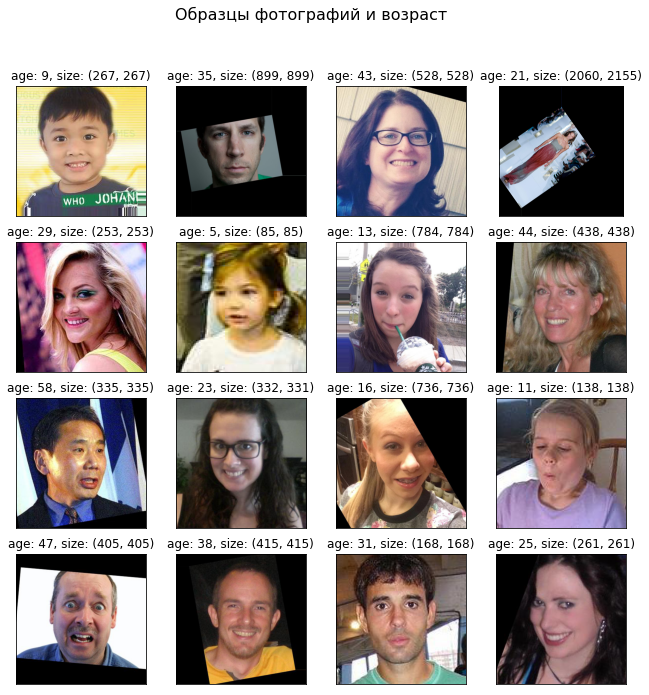

In [10]:
samples_imshow(4, 4)

* Фото разного размера;
* Общая ориентация фотографий - вертикальная, разворачивать их не нужно так как на кассе фото будет в той же ориентации.

На фотографиях замечены следующие дефекты:

* Есть повернутые фотографии;
* Различная яркость изображения;
* Обрезанные изображения;
* Размытые изображения.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Молодец, что красиво оформляешь свой график с фото)

### Выводы

***Анализ данных:***

* Данные распределенны нормально;
* На круглых датах (25, 30, 40, 50 лет и т.д.) заметны сильные скачки, это может быть связанно с тем что при разметки данных, настоящий возраст людей был известен не всегда, эти некорректные данные могут повлиять на качество модели.

Статистические данные:

* Размер выборки - 7591;
* Средний возраст - 31 год, медианный - 29 лет;
* Минимальный возраст - 1 год;
* Максимальный возраст - 100 лет.

***Анализ фотографий:***

* Фото разного размера;
* Общая ориентация фотографий - вертикальная, разворачивать их не нужно так как на кассе фото будет в той же ориентации.

На фотографиях замечены следующие дефекты:

* Есть повернутые фотографии;
* Различная яркость изображения;
* Обрезанные изображения;
* Размытые изображения.

## Обучение модели

***Код обучения модели:***

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255, 
                                 horizontal_flip=True,
                                 brightness_range=[0.5, 1.0],
                                 width_shift_range=0.1,
                                 height_shift_range=0.1)
    
    train_datagen_flow = datagen.flow_from_dataframe(
                        dataframe=labels,
                        directory=path + 'final_files/',
                        x_col='file_name',
                        y_col='real_age',
                        target_size=(224, 224),
                        batch_size=32,
                        class_mode='raw',
                        subset='training',
                        seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    test_datagen_flow = datagen.flow_from_dataframe(
                        dataframe=labels,
                        directory=path + 'final_files/',
                        x_col='file_name',
                        y_col='real_age',
                        target_size=(224, 224),
                        batch_size=32,
                        class_mode='raw',
                        subset='validation',
                        seed=12345)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                   weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                   include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=30,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

***Результы вывода модели на на экран:***

Found 5694 validated image filenames. \
Found 1897 validated image filenames. \

Train for 178 steps, validate for 60 steps \

Epoch 1/30 \
178/178 - 115s - loss: 236.0632 - mae: 11.1327 - val_loss: 747.9631 - val_mae: 22.4217 \
Epoch 2/30 \
178/178 - 107s - loss: 89.7417 - mae: 7.2073 - val_loss: 470.4580 - val_mae: 16.3902 \
Epoch 3/30 \
178/178 - 106s - loss: 72.0490 - mae: 6.4597 - val_loss: 242.4845 - val_mae: 11.4473 \
Epoch 4/30 \
178/178 - 109s - loss: 56.7916 - mae: 5.7304 - val_loss: 111.7185 - val_mae: 7.9559 \
Epoch 5/30 \
178/178 - 106s - loss: 45.3668 - mae: 5.1780 - val_loss: 88.3949 - val_mae: 7.0894 \
Epoch 6/30 \
178/178 - 104s - loss: 38.5745 - mae: 4.7589 - val_loss: 75.1987 - val_mae: 6.4435 \
Epoch 7/30 \
178/178 - 101s - loss: 33.0942 - mae: 4.4377 - val_loss: 99.5199 - val_mae: 7.7765 \
Epoch 8/30 \
178/178 - 102s - loss: 28.3938 - mae: 4.1559 - val_loss: 71.7542 - val_mae: 6.1822 \
Epoch 9/30 \
178/178 - 103s - loss: 24.2234 - mae: 3.8223 - val_loss: 80.2050 - val_mae: 6.5560 \
Epoch 10/30 \
178/178 - 103s - loss: 23.9353 - mae: 3.7917 - val_loss: 71.5998 - val_mae: 6.3435 \
Epoch 11/30 \
178/178 - 102s - loss: 21.6280 - mae: 3.5910 - val_loss: 100.5444 - val_mae: 7.6295 \
Epoch 12/30 \
178/178 - 102s - loss: 17.8256 - mae: 3.2582 - val_loss: 67.1706 - val_mae: 6.0825 \
Epoch 13/30 \
178/178 - 101s - loss: 15.6211 - mae: 3.0450 - val_loss: 71.8916 - val_mae: 6.1423 \
Epoch 14/30 \
178/178 - 98s - loss: 15.2851 - mae: 3.0214 - val_loss: 85.3260 - val_mae: 6.8449 \
Epoch 15/30 \
178/178 - 105s - loss: 14.5396 - mae: 2.9592 - val_loss: 69.0483 - val_mae: 6.2393 \
Epoch 16/30 \
178/178 - 105s - loss: 13.0795 - mae: 2.7658 - val_loss: 62.6006 - val_mae: 5.8336 \
Epoch 17/30 \
178/178 - 107s - loss: 11.7186 - mae: 2.6415 - val_loss: 64.6434 - val_mae: 6.0026 \
Epoch 18/30 \
178/178 - 106s - loss: 10.9877 - mae: 2.5633 - val_loss: 66.4952 - val_mae: 5.9831 \
Epoch 19/30 \
178/178 - 114s - loss: 10.9869 - mae: 2.5409 - val_loss: 65.9847 - val_mae: 6.0442 \
Epoch 20/30 \
178/178 - 110s - loss: 11.3571 - mae: 2.5815 - val_loss: 75.6958 - val_mae: 6.5230 \
Epoch 21/30 \
178/178 - 110s - loss: 16.4476 - mae: 3.0282 - val_loss: 81.4091 - val_mae: 6.4700 \
Epoch 22/30 \
178/178 - 102s - loss: 16.9102 - mae: 3.1364 - val_loss: 66.0723 - val_mae: 5.9909 \
Epoch 23/30 \
178/178 - 100s - loss: 11.3008 - mae: 2.5735 - val_loss: 66.9730 - val_mae: 6.2138 \
Epoch 24/30 \
178/178 - 98s - loss: 9.4833 - mae: 2.3668 - val_loss: 58.3637 - val_mae: 5.5550 \
Epoch 25/30 \
178/178 - 99s - loss: 8.6920 - mae: 2.2657 - val_loss: 60.2098 - val_mae: 5.6742 \
Epoch 26/30 \
178/178 - 98s - loss: 7.9967 - mae: 2.1674 - val_loss: 61.3114 - val_mae: 5.7200 \
Epoch 27/30 \
178/178 - 104s - loss: 7.7922 - mae: 2.1353 - val_loss: 62.9812 - val_mae: 5.7961 \
Epoch 28/30 \
178/178 - 103s - loss: 7.9118 - mae: 2.1533 - val_loss: 59.8020 - val_mae: 5.6555 \
Epoch 29/30 \
178/178 - 105s - loss: 7.7120 - mae: 2.1147 - val_loss: 59.2349 - val_mae: 5.7015 \
Epoch 30/30 \
178/178 - 105s - loss: 7.2727 - mae: 2.0657 - val_loss: 58.8370 - val_mae: 5.6171 \

60/60 - 10s - loss: 58.8370 - mae: 5.6171 \
Test MAE: 5.6171

## Анализ обученной модели

* Лучшая достигнутая метрика MAE модели - 5.6171, что ниже заданного максимального значение 8.

<br>***Ответы на поставленные задачи:***

* Данная модель должна хорошо справляться с предложениями товаров по различным возрастным группам, так как удалось достигнуть небольшого значение метрики MAE (5,62);
* "Контролировать добросовестность кассиров при продаже алкоголя" - необходимо провести дополнительное исследование, чтобы понять какова точность модели в возрастнной группе до 18 лет, со значением MAE 5.62 нельзя решить данную задачу на приемлимом уровне.

<br>***Рекомендации:***

* Стоит провести дополнительные исследования с различными возрастными группами, так как значение MAE может сильно разнится, у людей в возрасте до 20 лет происходят наиболее резкие изменения внешности, а у людей 60+ лет наоборт изменения внешности минимальные, следовательно и точность модели в разных возрастных группах может сильно отличаться. Цена ошибки модели в возрастной группе до 18 лет более высока (продажа алкоголя несовершеннолетним), чем в возрастной группе 60+;
* Пока человек стоит на кассе можно сделать несколько фото и усреднить значения полученных с них, для более точной оценки.

<br>***Статистические данные распределения возраста:***

* На круглых датах (25, 30, 40, 50 лет и т.д.) заметны сильные скачки, это может быть связанно с тем что при разметки данных, настоящий возраст людей был известен не всегда, эти некорректные данные могут повлиять на качество модели.
* Средний возраст - 31 год, медианный - 29 лет;
* Минимальный возраст - 1 год;
* Максимальный возраст - 100 лет.

***Анализ фотографий:***

* Фото разного размера;
* Общая ориентация фотографий - вертикальная, разворачивать их не нужно так как на кассе фото будет в той же ориентации.

На фотографиях замечены следующие дефекты:

* Есть повернутые фотографии;
* Различная яркость изображения;
* Обрезанные изображения;
* Размытые изображения.